In [1]:
from OpenMiChroM.CndbTools import cndbTools
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
path = '/Users/douglas/Documents/Features Transfer/trajectories/' # path to sample trajectory cndb, ndb, and pdbs files.

cndbTools = cndbTools()

cndbTools.load(path+'traj_0.cndb')

In [6]:
def cosine_array(frame): # For a given frame, gives the list of cosines of angles to the first bond
    cosine_list = []
    vec_0 = frame[1] - frame[0] # Displacement vector between the first two beads in the frame
    N_beads = len(frame) # Number of beads in the chain input as xyz
    for j in range(N_beads-1):
        vec_j = frame[j+1] - frame[j] # Displacement vector between the j and j+1 th beads in the frame
        cosine_j = np.vdot(vec_0,vec_j)/(np.linalg.norm(vec_0)*np.linalg.norm(vec_j)) # cosine of the angle between vec_0 and vec_j
        cosine_list.append(cosine_j)
    cosine_array = np.array(cosine_list)
    return cosine_array

def cosine_average_array(xyz): # Average the cosine_array for each frame in the xyz trajectory
    N_beads = len(xyz[0])
    N_blocks = len(xyz)
    total_cosine_array = np.zeros(N_beads-1)
    for i in range(N_blocks):
        frame = xyz[i]
        frame_cosine_array = cosine_array(frame)
        total_cosine_array += frame_cosine_array
    total_cosine_array /= N_blocks
    return total_cosine_array

def decaying_exponential(L, persistence_length):
    return np.exp(-L/persistence_length)

def persistence_length(cosine_average_array): # Given an array of cosines, fits to a decaying exponential and outputs the length scale
    ds = np.array(range(len(cosine_average_array))) # Array of genomic distances along the chromosome fiber from the beginning
    initial_guess = (1.0)
    popt, pcov = curve_fit(decaying_exponential, ds,cosine_average_array, p0=initial_guess) # Fit the data
    persistence_length_opt = popt[0] # Extract the optimized persistence length
    return persistence_length_opt

In [7]:
cos_tight = cosine_average_array(traj_0_tight)
pers_tight = persistence_length(cos_tight)
print('tight persistence length',pers_tight)

cos_loose = cosine_average_array(traj_0_loose)
pers_loose = persistence_length(cos_loose)
print('loose persistence length',pers_loose)

tight persistence length 1.8650878136340376
loose persistence length 1.907171394180237


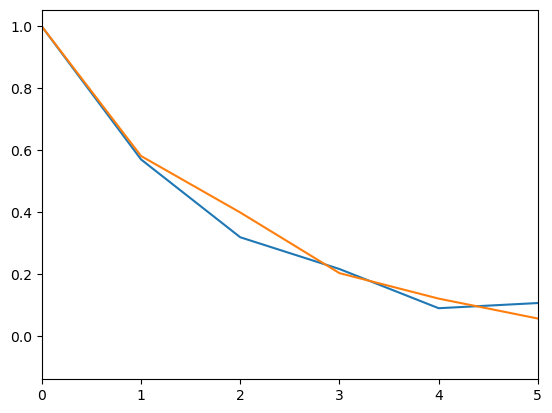

In [8]:
plt.plot(cos_tight,label='tight')
plt.plot(cos_loose,label='loose')
plt.xlim(0,5)
plt.show()

In [18]:
pers_length_tight_segment_list = []
L_0 = 10
for i in range(0,1000-L_0,L_0):
    tight_segment = cndbTools.xyz(frames=[10000,50000,100], beadSelection=range(i,i+L_0), XYZ=[0,1,2])
    cos_tight_segment = cosine_average_array(tight_segment)
    pers_tight_segment = persistence_length(cos_tight_segment)
    pers_length_tight_segment_list.append(pers_tight_segment)

pers_length_tight_array = np.array(pers_length_tight_segment_list)
pers_length_tight_average = np.average(pers_length_tight_array)
pers_length_tight_std_dev = np.std(pers_length_tight_array)

print('The persistence length of a tight region is',round(pers_length_tight_average,1),'+/-',round(pers_length_tight_std_dev,1),'.')

The persistence length of a tight region is 1.72 +/- 0.09 .


In [19]:
pers_length_loose_segment_list = []
L_0 = 10
for i in range(1000,1500-L_0,L_0):
    loose_segment = cndbTools.xyz(frames=[10000,50000,100], beadSelection=range(i,i+L_0), XYZ=[0,1,2])
    cos_loose_segment = cosine_average_array(loose_segment)
    pers_loose_segment = persistence_length(cos_loose_segment)
    pers_length_loose_segment_list.append(pers_loose_segment)

pers_length_loose_array = np.array(pers_length_loose_segment_list)
pers_length_loose_average = np.average(pers_length_loose_array)
pers_length_loose_std_dev = np.std(pers_length_loose_array)

print('The persistence length of a loose region is',round(pers_length_loose_average,1),'+/-',round(pers_length_loose_std_dev,1),'.')

The persistence length of a loose region is 1.67 +/- 0.1 .
